In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, expected_returns, plotting
import yfinance as yf


from datetime import date

In [2]:
risk_free = 0.08                                #УКАЖИТЕ ГОДОВОЙ ДОХОД БЕЗРИСКОВЫХ ИНВЕСТИЦИЙ
total_money = 4000                                #УКАЖИТЕ НА КАКУЮ СУММУ СОБРАТЬ ПОРТФЕЛЬ

listtick = []
#listtick = "aflt.me gazp.me gche.me gltr.me irao.me mgnt.me moex.me mtlr.me 
# mtss.me nkncp.me nvtk.me ozon.me pikk.me poly.me qiwi.me rosn.me rtkm.me 
# sgzh.me sibn.me sngsp.me tatn.me trmk.me vkco.me".upper().split(" ")   #НАПИСАТЬ ТИКЕРЫ ВРУЧНУЮ

k = 100                                         #ИНАЧЕ ВЗЯТЬ k КРУПНЕЙШИХ КОМПАНИЙ NASDAC ИЗ ФАЙЛА
if len(listtick) == 0:
    listtick = pd.read_csv('nasdaq_screener_1684050394168.csv')
    listtick = listtick.sort_values("Market Cap", ascending=False).iloc[:k].Symbol.to_list()

print(listtick)

['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'BRK/A', 'BRK/B', 'NVDA', 'META', 'TSLA', 'JNJ', 'V', 'UNH', 'TSM', 'XOM', 'LLY', 'WMT', 'JPM', 'NVO', 'PG', 'MA', 'MRK', 'CVX', 'HD', 'KO', 'PEP', 'ORCL', 'AVGO', 'ABBV', 'ASML', 'AZN', 'COST', 'BABA', 'NVS', 'MCD', 'BAC', 'PFE', 'SHEL', 'TMO', 'CRM', 'TM', 'ABT', 'CSCO', 'NKE', 'LIN', 'FMX', 'ACN', 'TMUS', 'CMCSA', 'DIS', 'DHR', 'VZ', 'NEE', 'AMD', 'ADBE', 'SAP', 'NFLX', 'HSBC', 'PM', 'BHP', 'TTE', 'TXN', 'UPS', 'WFC', 'BMY', 'RTX', 'MS', 'UL', 'SNY', 'RY', 'HON', 'HDB', 'AMGN', 'SBUX', 'T', 'UNP', 'LOW', 'BUD', 'INTC', 'COP', 'BA', 'INTU', 'MDT', 'SPGI', 'SONY', 'PLD', 'QCOM', 'LMT', 'TD', 'IBM', 'DE', 'AXP', 'ELV', 'SYK', 'CAT', 'GE', 'ISRG', 'GS', 'MDLZ', 'BP']


Скачиваем котировки:

In [3]:
today = str(date.today())
print(today) 

df = yf.download(listtick, start = "2009-01-01", end=today).Close.dropna(axis=1, how='all')
df.tail()

2023-05-14
[*********************100%***********************]  100 of 100 completed

2 Failed downloads:
- BRK/B: No timezone found, symbol may be delisted
- BRK/A: No timezone found, symbol may be delisted


,AAPL,ABBV,ABT,ACN,ADBE,AMD,AMGN,AMZN,ASML,AVGO,...,TXN,UL,UNH,UNP,UPS,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-08 00:00:00,173.500000,147.449997,110.900002,264.820007,344.059998,95.040001,234.619995,105.830002,654.989990,629.059998,...,164.220001,55.320000,492.619995,199.940002,174.389999,232.229996,37.830002,38.380001,152.720001,109.110001
2023-05-09 00:00:00,171.770004,146.830002,110.250000,263.480011,342.649994,95.059998,234.429993,106.620003,643.049988,618.510010,...,163.000000,54.820000,490.380005,200.589996,173.009995,233.259995,37.570000,38.540001,152.979996,109.139999
2023-05-10 00:00:00,173.559998,146.419998,110.690002,268.890015,344.019989,97.019997,234.110001,110.190002,657.140015,626.270020,...,163.050003,54.130001,490.070007,199.059998,171.570007,231.270004,37.630001,38.279999,152.550003,107.739998
2023-05-11 00:00:00,173.750000,146.589996,110.050003,272.269989,341.579987,97.099998,232.289993,112.180000,650.190002,627.669983,...,161.169998,54.279999,488.760010,198.080002,170.229996,231.009995,37.599998,38.330002,153.119995,105.790001
2023-05-12 00:00:00,172.570007,147.149994,110.489998,277.190002,335.450012,95.260002,232.949997,110.260002,647.510010,631.150024,...,161.880005,54.209999,491.230011,198.990005,168.500000,231.380005,37.590000,37.490002,153.070007,105.779999


По приколу выведем котировки 10-ти каких то акций

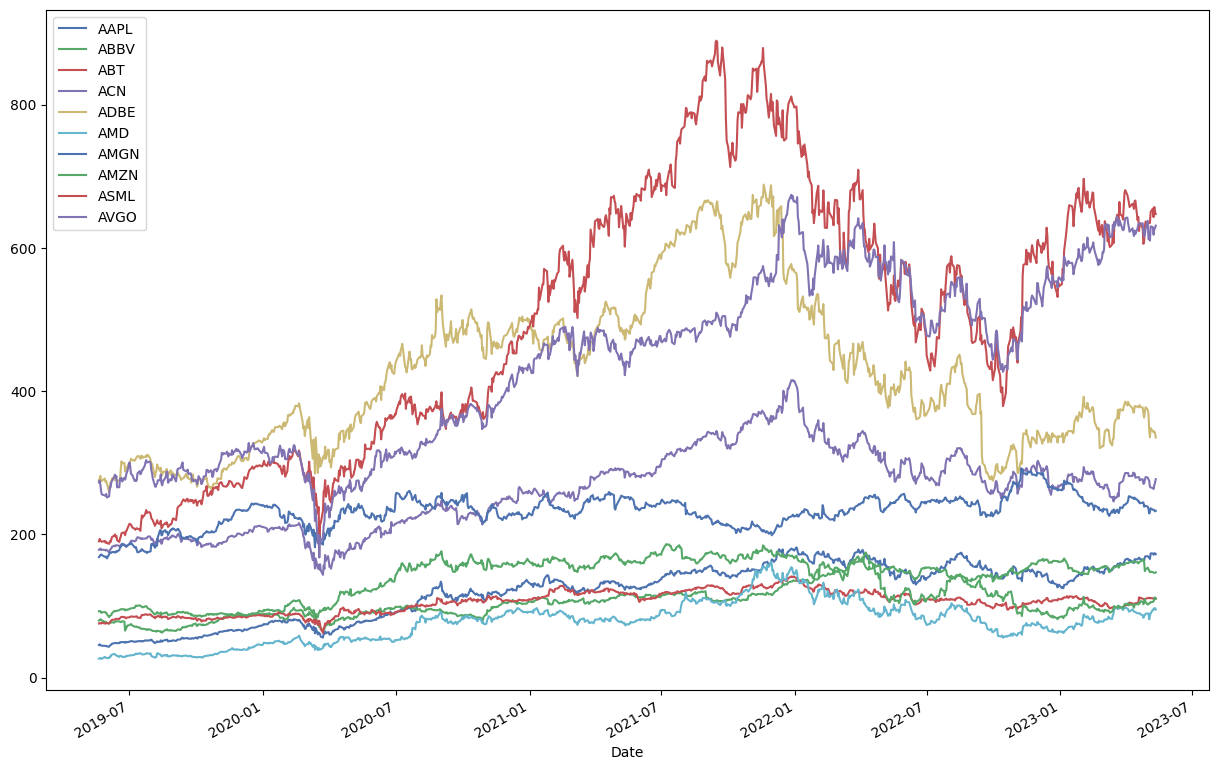

In [4]:
if len(df) >= 10 :
    df.iloc[-1004:, 0:10].plot(figsize=(15,10))
else:
    df.plot(figsize=(15,10))

Теперь сделаем матрицу ковариации наших активов.

<Axes: >

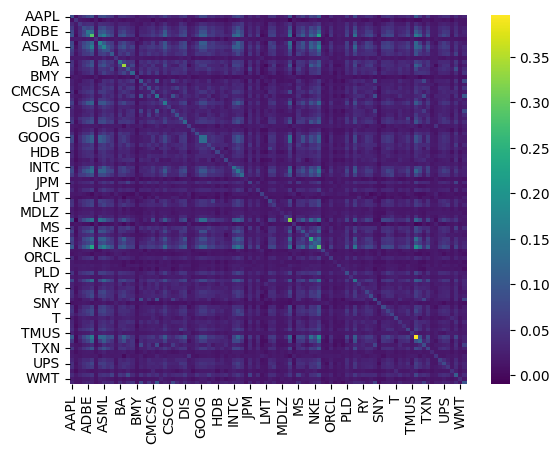

In [5]:
rm = risk_models.risk_matrix(df, method="exp_cov", span=252)
rm = pypfopt.risk_models.fix_nonpositive_semidefinite(rm)

sns.heatmap(rm, cmap='viridis')

Теперь посчитаем оценку для доходностей каждого актива

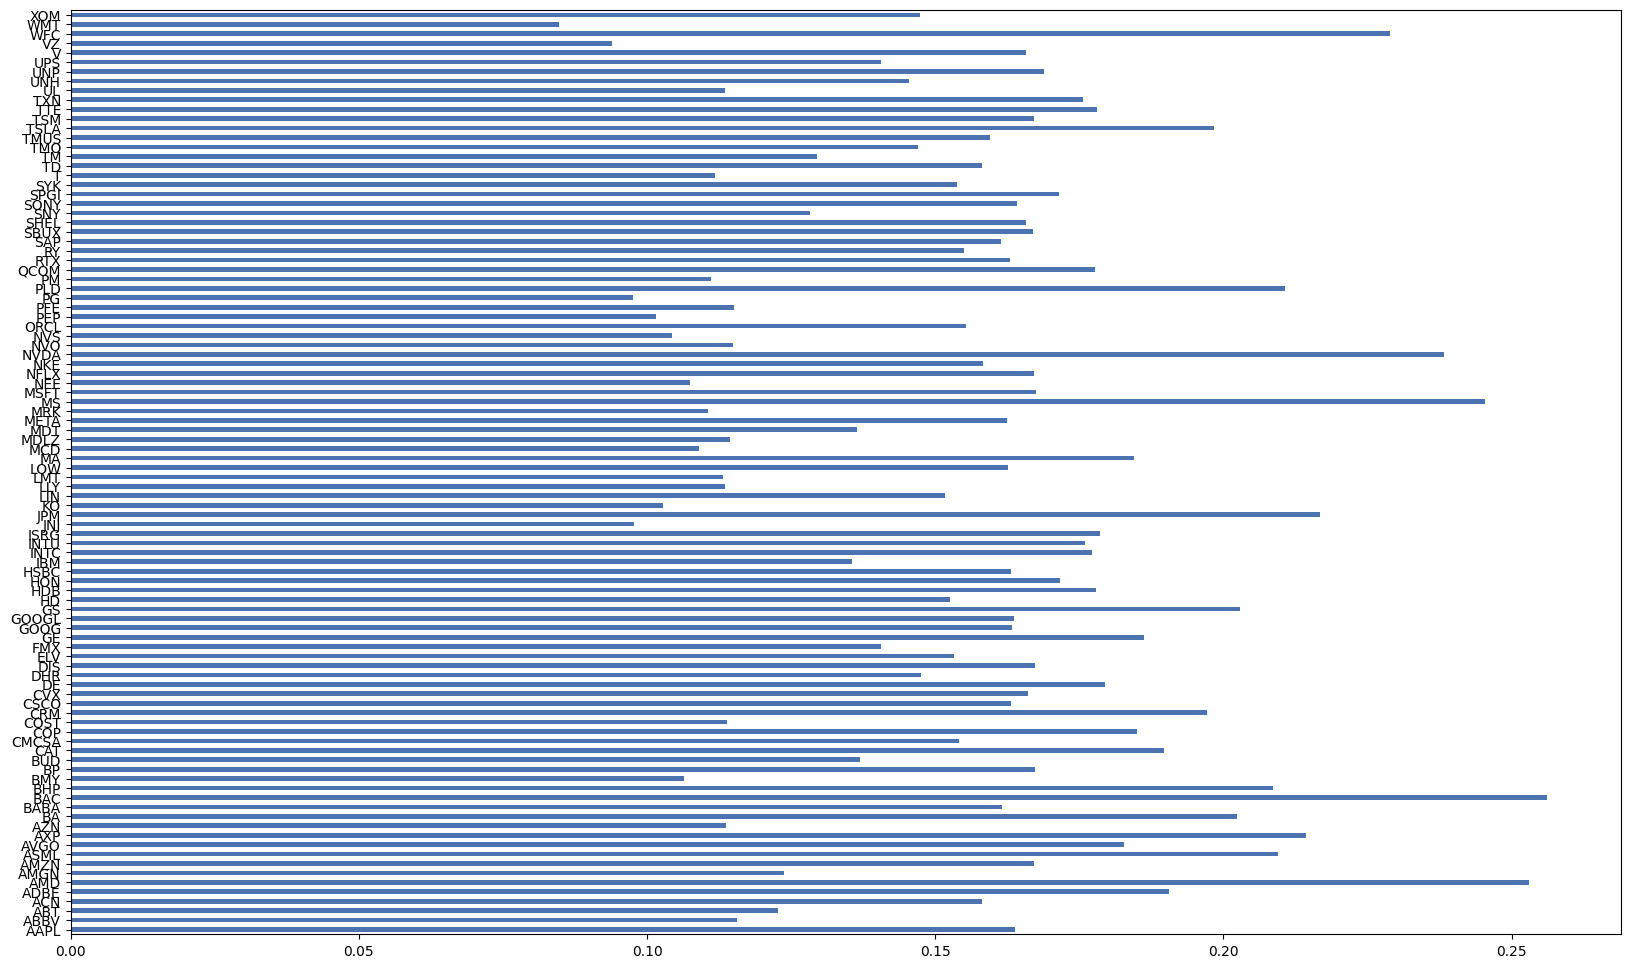

In [6]:
er = expected_returns.return_model(df, method="capm_return")
er.plot.barh(figsize=(20, 12));

Теперь сделаем оптимизацию портфеля

c:\users\mi\appdata\local\programs\python\python39\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Колличество активов в портфеле:  28
Параметры полученого портфеля: 
Expected annual return: 20.2%
Annual volatility: 19.2%
Sharpe Ratio: 0.64
Полученные веса портфеля: 
ABBV    0.00878
AMD     0.03770
AMGN    0.01825
AXP     0.01530
BA      0.00291
BAC     0.13155
BHP     0.06857
COP     0.00525
CSCO    0.02006
DE      0.01473
ELV     0.03253
FMX     0.00138
GE      0.02265
GS      0.02412
HDB     0.06898
HON     0.02330
JPM     0.05607
MA      0.01497
MS      0.12304
PLD     0.08061
RTX     0.01975
SNY     0.03284
SONY    0.00642
TMUS    0.06798
TTE     0.02546
UNH     0.03348
UNP     0.00909
WFC     0.03423
dtype: float64


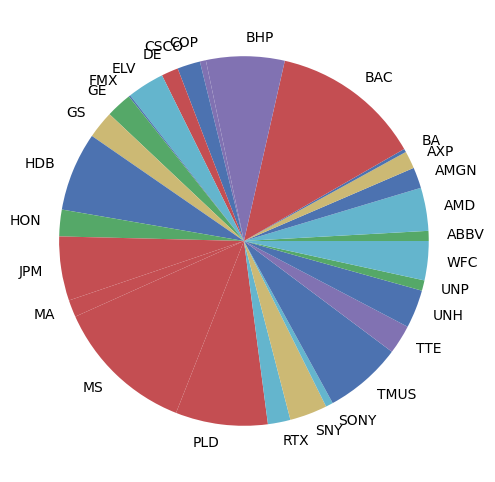

In [7]:
ef = pypfopt.EfficientFrontier(er, rm)
ef.add_objective(pypfopt.objective_functions.L2_reg, gamma=0.1)  #УВЕЛИЧИТЬ ПАРАМЕТР ГАММА ЕСЛИ ХОЧЕТСЯ БОЛЬШЕ АКЦИЙ В ПОРТФЕЛЕ
ef.max_sharpe(risk_free)

print("Колличество активов в портфеле: ", np.count_nonzero(np.array(list(ef.clean_weights().values()))))
print("Параметры полученого портфеля: ")

ef.portfolio_performance(verbose=True, risk_free_rate=risk_free)

pd.Series(ef.clean_weights(), index = ef.tickers).plot.pie(figsize=(6, 6));
print("Полученные веса портфеля: ")
weig = pd.Series(ef.clean_weights())
print(weig[weig != 0])

c:\users\mi\appdata\local\programs\python\python39\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Дискретный портфель с остатком денег: $237.44
AMD      2
BAC     20
BHP      5
CSCO     2
GE       1
GS       1
HDB      4
JPM      2
MS       6
PLD      3
RTX      1
SNY      3
TMUS     2
TTE      2
WFC      4
dtype: int32


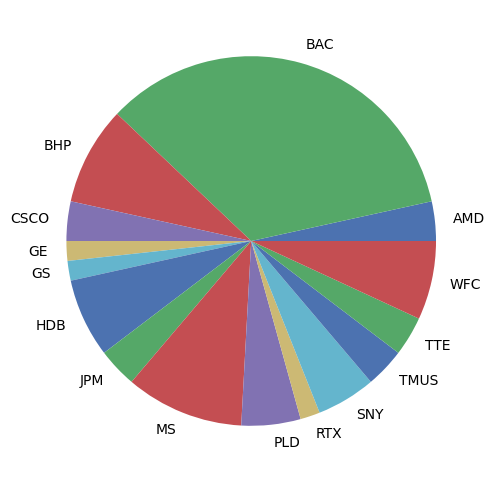

In [8]:
da = pypfopt.DiscreteAllocation(ef.clean_weights(), df.iloc[-1], total_portfolio_value=total_money) #ВЫЧЕСЛИТЬ В ЦЕЛЫХ ЧИСЛАХ
alloc, leftover = da.lp_portfolio()
print(f"Дискретный портфель с остатком денег: ${leftover:.2f}")
print(pd.Series(alloc))
pd.Series(alloc).plot.pie(figsize=(6, 6));

Далее пример кода показывающий как любой случайный портфель ~~отсасывает~~ проигрывает у портфеля найденного методом оптимизации. Создадим случайные 10000 портфелей и сравним с оптимальным

In [9]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(er)), n_samples)
rets = w.dot(er)
stds = np.sqrt((w.T * (rm @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.16215462 0.15973436 0.16070059 ... 0.14980211 0.15580888 0.15985713]
Sample portfolio volatilities: 0       0.180820
1       0.183738
2       0.184968
3       0.169788
4       0.185869
          ...   
9995    0.192226
9996    0.183617
9997    0.164262
9998    0.175419
9999    0.181797
Length: 10000, dtype: float64


c:\users\mi\appdata\local\programs\python\python39\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\users\mi\appdata\local\programs\python\python39\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


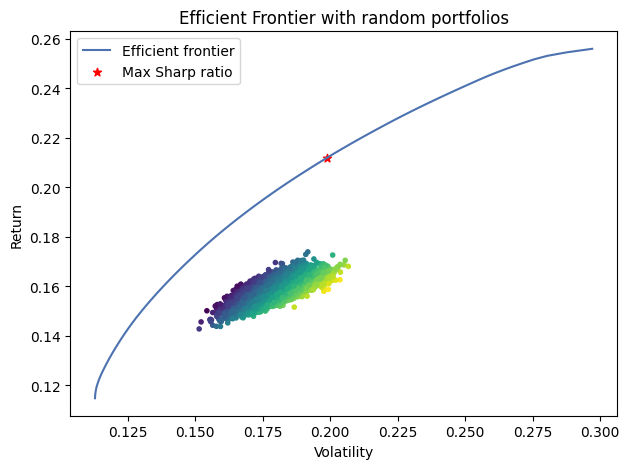

In [10]:
# Plot efficient frontier with Monte Carlo sim
ef = pypfopt.EfficientFrontier(er, rm)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = pypfopt.EfficientFrontier(er, rm)
ef2.max_sharpe(risk_free_rate=risk_free)
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.scatter(std_tangent, ret_tangent, marker="*", label="Max Sharp ratio", c="red") 
# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

На данном графике по вертикале доходность, а по горизонтали величина отклонения в год. Грубо говоря наше оптимальное решение в год будет приносить 18% $\pm$ 15%  . Любой портфель не находящийся на фронте эффективности хуже.